In [1]:
import os
import sys
from enum import IntEnum

import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm

import torch
from torch_geometric.transforms import LineGraph
from torch_geometric.data import Data

scripts_path = "/home/dnguyen/gnn_predicting_effects_of_traffic_policies/scripts"
project_root = "/home/dnguyen/gnn_predicting_effects_of_traffic_policies"

from help_functions import *

# Paths to raw simulation data
sim_input_paths = [
    os.path.join(
        project_root,
        "data",
        "raw_data",
        "exp_dist_not_connected_5k",
        "output_networks_1000",
    )
]

# Path to save the processed simulation data
result_path = os.path.join(
    project_root, "data", "train_data", "edge_features_with_net_flow"
)

# Path to the basecase links and stats
basecase_links_path = os.path.join(
    project_root,
    "data",
    "links_and_stats",
    "pop_1pct_basecase_average_output_links.geojson",
)
basecase_stats_path = os.path.join(
    project_root, "data", "links_and_stats", "pop_1pct_basecase_average_mode_stats.csv"
)

# Flag to use line graph transformation
use_linegraph = True

# Flag to use allowed modes or not
use_allowed_modes = False


class EdgeFeatures(IntEnum):
    VOL_BASE_CASE = 0
    CAPACITY_BASE_CASE = 1
    CAPACITY_REDUCTION = 2
    FREESPEED = 3
    HIGHWAY = 4
    LENGTH = 5
    ALLOWED_MODE_CAR = 6
    ALLOWED_MODE_BUS = 7
    ALLOWED_MODE_PT = 8
    ALLOWED_MODE_TRAIN = 9
    ALLOWED_MODE_RAIL = 10
    ALLOWED_MODE_SUBWAY = 11
    NET_FLOW = 12

In [3]:
# Read all network data into a dictionary of GeoDataFrames
def compute_result_dic(basecase_links, networks):

    result_dic_output_links = {}
    result_dic_eqasim_trips = {}
    result_dic_output_links["base_network_no_policies"] = basecase_links

    for network in tqdm(networks[:10], desc="Processing Networks", unit="network"):

        policy_key = create_policy_key(network)
        df_output_links = read_output_links(network)
        df_eqasim_trips = read_eqasim_trips(network)
        if df_output_links is not None and df_eqasim_trips is not None:
            df_output_links.drop(columns=["geometry"], inplace=True)
            gdf_extended = extend_geodataframe(
                gdf_base=basecase_links,
                gdf_to_extend=df_output_links,
                column_to_extend="highway",
                new_column_name="highway",
            )
            gdf_extended = extend_geodataframe(
                gdf_base=basecase_links,
                gdf_to_extend=gdf_extended,
                column_to_extend="vol_car",
                new_column_name="vol_car_base_case",
            )
            result_dic_output_links[policy_key] = gdf_extended
            df_eqasim_trips_list = [df_eqasim_trips]
            mode_stats = calculate_avg_mode_stats(df_eqasim_trips_list)
            result_dic_eqasim_trips[policy_key] = mode_stats

    return result_dic_output_links, result_dic_eqasim_trips


networks = list()


for path in sim_input_paths:
    networks += [os.path.join(path, network) for network in os.listdir(path)]

networks = [
    network
    for network in networks
    if os.path.isdir(network) and not network.endswith(".DS_Store")
]
networks.sort()

gdf_basecase_links = gpd.read_file(basecase_links_path)
gdf_basecase_links = gdf_basecase_links.set_crs("EPSG:4326", allow_override=True)
gdf_basecase_mean_mode_stats = pd.read_csv(basecase_stats_path, delimiter=",")

result_dic_output_links, result_dic_eqasim_trips = compute_result_dic(
    basecase_links=gdf_basecase_links, networks=networks
)
base_gdf = result_dic_output_links["base_network_no_policies"]

_, stacked_edge_geometries_tensor, edges_base, nodes = get_link_geometries(base_gdf)

Processing Networks: 100%|██████████| 10/10 [00:03<00:00,  3.05network/s]


In [4]:
print(base_gdf.columns)
print(len(base_gdf))
print(type(base_gdf))
print(base_gdf["vol_car"])

# plot distribution of vol_car, highway, and freespeed

Index(['link', 'from_node', 'to_node', 'length', 'freespeed', 'capacity',
       'lanes', 'modes', 'vol_car', 'osm:relation:route_master',
       'osm:way:vehicle', 'osm:way:traffic_calming', 'osm:way:junction',
       'osm:way:motorcycle', 'isUrban', 'osm:way:lanes', 'osm:way:service',
       'osm:way:psv', 'osm:way:id', 'osm:way:access', 'osm:way:oneway',
       'highway', 'osm:relation:route', 'osm:way:railway', 'osm:way:name',
       'storageCapacityUsedInQsim', 'osm:way:tunnel', 'variance', 'cv_percent',
       'std_dev', 'std_dev_multiplied', 'geometry', 'from_idx', 'to_idx'],
      dtype='object')
31635
<class 'geopandas.geodataframe.GeoDataFrame'>
0        51.448980
1        52.979592
2        23.744898
3        60.071429
4        66.020408
           ...    
31630     0.000000
31631     0.000000
31632     0.000000
31633     0.000000
31634     0.000000
Name: vol_car, Length: 31635, dtype: float64


In [5]:
for i in range(0, len(base_gdf)):
    print(i)
    if base_gdf.iloc[i]["osm:way:oneway"] != "yes":
        break

0
1


In [7]:
vol_base_case = base_gdf["vol_car"].values

net_flow = np.zeros_like(vol_base_case)
for i, (src, dst) in enumerate(edges_base):
    row = base_gdf.query(
        f"from_idx == @src and to_idx == @dst"
    )
    row2 = base_gdf.query(
        f"from_idx == @dst and to_idx == @src"
    )
    if not row.empty and not row2.empty:
        print(row)
        print(row2)
        break

     link   from_node   to_node     length  freespeed  capacity  lanes  \
1  100316  5904976363  24983651  14.860209   8.333333     480.0    1.0   

                      modes    vol_car osm:relation:route_master  ...  \
1  bus,car,car_passenger,pt  52.979592                      None  ...   

           osm:way:name storageCapacityUsedInQsim osm:way:tunnel   variance  \
1  Carrefour de l'Odéon                       NaN           None  24.897543   

  cv_percent   std_dev std_dev_multiplied  \
1   9.418237  4.989744            3.98124   

                                          geometry  from_idx to_idx  
1  LINESTRING (2.33874 48.85242, 2.33872 48.85229)         1      2  

[1 rows x 34 columns]
     link from_node     to_node     length  freespeed  capacity  lanes  \
2  100317  24983651  5904976363  14.860209   8.333333     960.0    2.0   

                      modes    vol_car osm:relation:route_master  ...  \
2  bus,car,car_passenger,pt  23.744898                      None  ...

In [7]:
print(base_gdf.iloc[1])

link                                                                    100316
from_node                                                           5904976363
to_node                                                               24983651
length                                                               14.860209
freespeed                                                             8.333333
capacity                                                                 480.0
lanes                                                                      1.0
modes                                                 bus,car,car_passenger,pt
vol_car                                                              52.979592
osm:relation:route_master                                                 None
osm:way:vehicle                                                           None
osm:way:traffic_calming                                                   None
osm:way:junction                                    

/tmp/ipykernel_2868688/486268866.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=highway_counts.values, y=highway_counts.index, ax=axs[2], palette="mako")


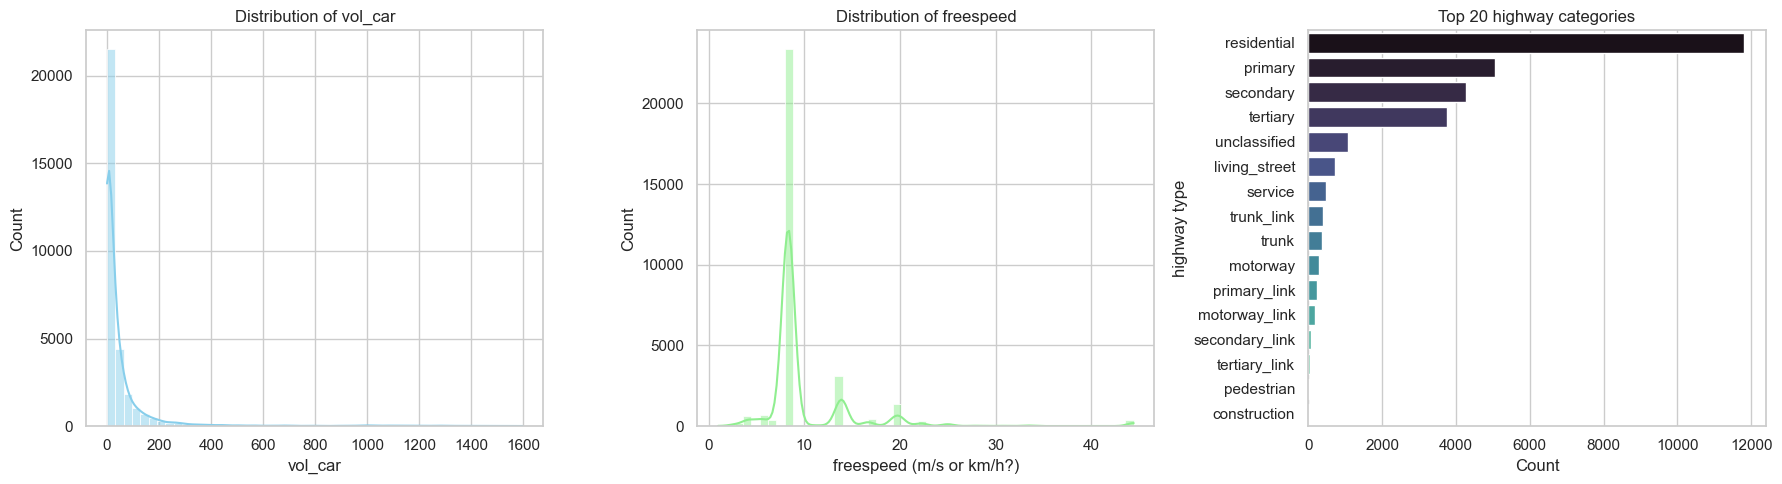

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for better aesthetics
sns.set(style="whitegrid")

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot distribution of vol_car
sns.histplot(
    base_gdf["vol_car"].dropna(), bins=50, kde=True, ax=axs[0], color="skyblue"
)
axs[0].set_title("Distribution of vol_car")
axs[0].set_xlabel("vol_car")

# Plot distribution of freespeed
sns.histplot(
    base_gdf["freespeed"].dropna(), bins=50, kde=True, ax=axs[1], color="lightgreen"
)
axs[1].set_title("Distribution of freespeed")
axs[1].set_xlabel("freespeed (m/s or km/h?)")

# Plot distribution of highway categories
highway_counts = base_gdf["highway"].value_counts().head(20)  # top 20 types
sns.barplot(x=highway_counts.values, y=highway_counts.index, ax=axs[2], palette="mako")
axs[2].set_title("Top 20 highway categories")
axs[2].set_xlabel("Count")
axs[2].set_ylabel("highway type")

plt.tight_layout()
plt.show()